<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/Modelisation_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import of the training data

from google.colab import files
uploaded = files.upload()

# Import of moduls

!pip install wikidata --quiet
!pip install datasets --quiet
!pip install spacy --quiet
!python -m spacy download en_core_web_md
!pip install tensorflow --quiet
%pip install fasttext

import matplotlib.pyplot as plt
import pandas as pd
from wikidata.client import Client
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import spacy
import seaborn as sns
from collections import Counter
import joblib
from google.colab import files
import tensorflow as tf
import fasttext.util
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import math

fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')


from tqdm.auto import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading the data
train_df = pd.read_json('train_df_complete.json', orient="records", lines=True)
dev_df = pd.read_json('dev_df_complete.json', orient="records", lines=True)

Saving dev_df_complete.json to dev_df_complete.json
Saving train_df_complete.json to train_df_complete.json
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 11.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



# Spacey embeddings
 Firstly we will try to classify the descriptions based of their representation in the embeddings space of the spacey embeddings. We will use the knn classifier

In [2]:
# Loading the pretrained model
nlp = spacy.load("en_core_web_md")

In [3]:
import nltk
from nltk.stem import PorterStemmer
nltk.download('punkt_tab')
porter = PorterStemmer()
def transform_description(description):
  description = nltk.word_tokenize(description)
  description = [porter.stem(word) for word in description]
  return np.mean([nlp(word).vector for word in description],axis=0)/len(description)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


  0%|          | 0/100 [00:00<?, ?it/s]

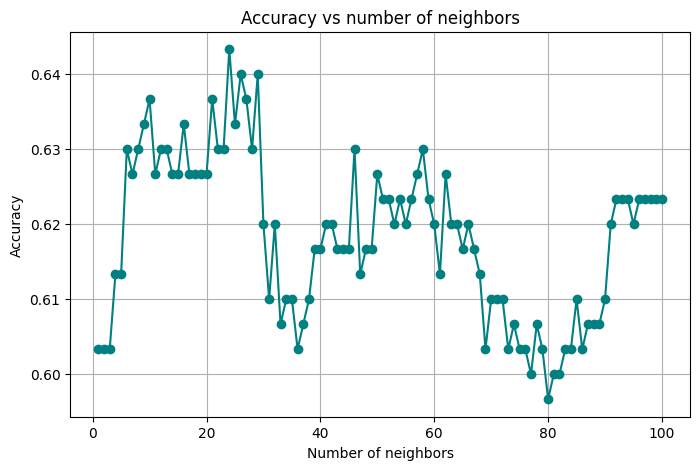

<Figure size 640x480 with 0 Axes>

In [4]:
# Exctract the texte and the label : Training
train_texts = train_df['description'].to_list()
train_labels = train_df['label_int'].to_list()

# Exctract the texte and the label : Dev
dev_texts = dev_df['description'].to_list()
dev_labels = dev_df['label_int'].to_list()


# Vectorize the texts with en_core_web_m

train_vectors = np.array([nlp(text).vector for text in train_texts])
dev_vectors = np.array([nlp(text).vector for text in dev_texts])

accuracies = {}

# We test many values of k (number of neighbors in KNN)
for k in tqdm(range(1, 101)):
    knn = NearestNeighbors(n_neighbors=k, metric='cosine')
    knn.fit(train_vectors)

    predicted_labels = []

    for vec in dev_vectors:
        distances, indices = knn.kneighbors(vec.reshape(1, -1))

        # Get the k closest labels
        neighbor_labels = [train_labels[idx] for idx in indices[0]]

        # Choose the label (the most frequent one)
        label_counts = {}
        for label in neighbor_labels:
            label_counts[label] = label_counts.get(label, 0) + 1
        majority_label = max(label_counts.items(), key=lambda x: x[1])[0]

        predicted_labels.append(majority_label)

    # Compute accuracy
    accuracy = accuracy_score(dev_labels, predicted_labels)
    accuracies[k] = accuracy

# Plot Accuracy vs Number of Neighbors
plt.figure(figsize=(8, 5))
plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o', color='teal')
plt.title("Accuracy vs number of neighbors")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()
plt.savefig('Accuracy_vs_neighbors_spacy')

In [5]:
# We get the best k : the one that gives the best accuracy
best_k = max(accuracies, key=accuracies.get)

# We train the final model, with best_k
knn = NearestNeighbors(n_neighbors=best_k, metric='cosine')
knn.fit(train_vectors)

# We predict the labels for each item of the dev set
final_predicted_labels = []
for vec in dev_vectors:
    distances, indices = knn.kneighbors(vec.reshape(1, -1))
    neighbor_labels = [train_labels[idx] for idx in indices[0]]
    majority_label = max(set(neighbor_labels), key=neighbor_labels.count)
    final_predicted_labels.append(majority_label)

dev_df['label_spacy_KNN'] = final_predicted_labels

In [6]:
dev_df['label_spacy_KNN'].value_counts()

,count
label_spacy_KNN,
2,141
0,112
1,47


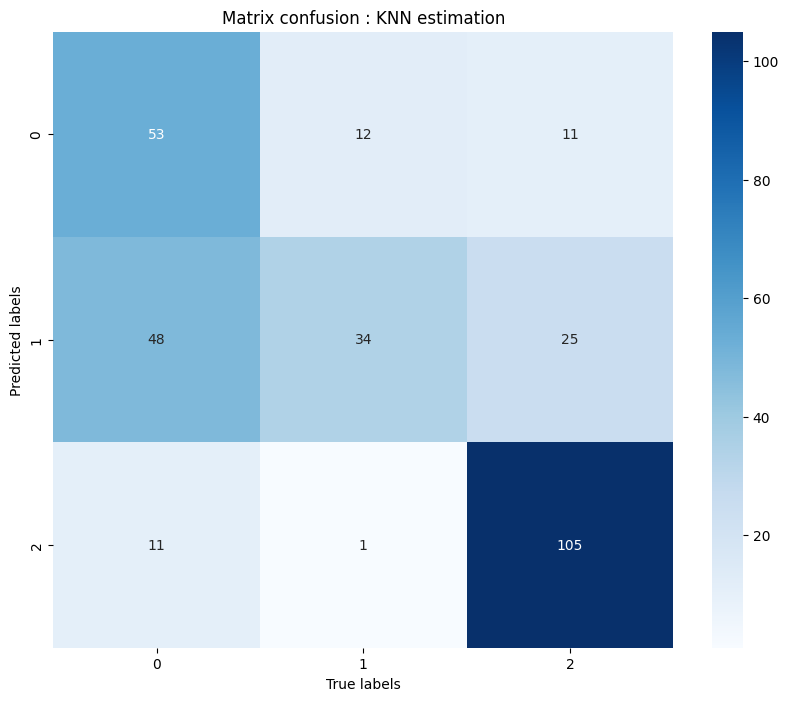

In [7]:
# Creation of the confusion matrix
y_true = dev_df['label_int']
y_pred = dev_df['label_spacy_KNN']
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Matrix confusion : KNN estimation')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [8]:
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred,average='macro')

print("Recall :", recall)
print("Precision :", precision)
print("F1-score :", f1)

Recall : 0.6375204426114411
Precision : 0.6470997973657547
F1-score : 0.6064472390548591


# Fastext embeddings, knn and nn based classifiers

 - Here we explore the fasttext embeddings, because hypothetically they could give a better representation in case of the proper names, as they do not return an "unknown" vector in case the word is not in the embeddings base, but a average of the ngrams of the word
 - additionaly, in case, of unknown words, we will count the number of them in description and add it as an additional dimension to the neural network input, because this may hypothetically be an informative feature with regards to our classification task
 - Lastly we have gotten rid of the stop words of the descriptions as they would not bring an informative value

In [9]:
nltk.download('stopwords')
nltk.download('punkt_tab')
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [10]:
'''transforming the descriptions to the embeddings space , adding the oov information'''
def transform_description(description):
  oov_words = 0
  description = nltk.word_tokenize(description)
  description = [word for word in description if word not in stop_words]
  description = [word.lower() for word in description]
  for word in description:
    if word not in ft.words:
      oov_words += 1
  description = " ".join(description)
  description_vector = ft.get_sentence_vector(description)
  description_vector = normalize(description_vector.reshape(1, -1), norm='l2')[0]
  description_vector = np.append(description_vector, oov_words)
  return description_vector

  0%|          | 0/9 [00:00<?, ?it/s]

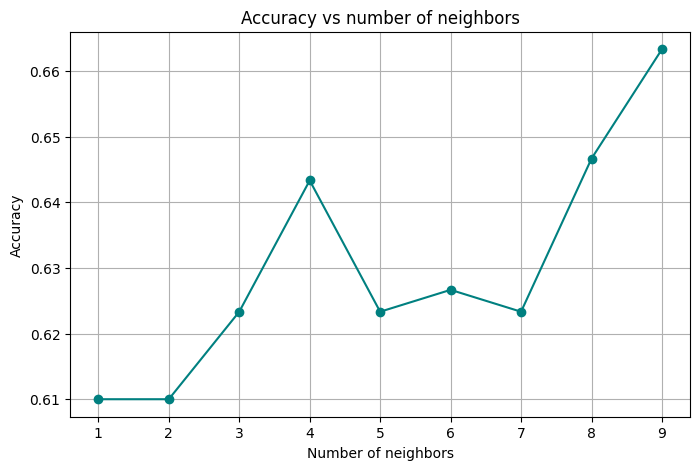

<Figure size 640x480 with 0 Axes>

In [11]:
# extract description and label for train and dev set
train_texts = train_df['description'].to_list()
train_labels = train_df['label_int'].to_list()
dev_texts = dev_df['description'].to_list()
dev_labels = dev_df['label_int'].to_list()

# Vectorize the texts with fasttext
train_vectors = np.array([transform_description(text) for text in train_texts])
dev_vectors = np.array([transform_description(text) for text in dev_texts])

accuracies = {}

# We test many values of k (number of neighbors in KNN)
for k in tqdm(range(1, 10)):
    knn = NearestNeighbors(n_neighbors=k, metric='cosine')
    knn.fit(train_vectors)

    predicted_labels = []

    for vec in dev_vectors:
        distances, indices = knn.kneighbors(vec.reshape(1, -1))

        # Get the k closest labels
        neighbor_labels = [train_labels[idx] for idx in indices[0]]

        # Choose the label (the most frequent one)
        label_counts = {}
        for label in neighbor_labels:
            label_counts[label] = label_counts.get(label, 0) + 1
        majority_label = max(label_counts.items(), key=lambda x: x[1])[0]

        predicted_labels.append(majority_label)

    # Compute accuracy
    accuracy = accuracy_score(dev_labels, predicted_labels)
    accuracies[k] = accuracy

# Plot Accuracy vs number of neighbors
plt.figure(figsize=(8, 5))
plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o', color='teal')
plt.title("Accuracy vs number of neighbors")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()
plt.savefig('Accuracy_vs_neighbors_fasttext')

In [12]:
# We get the best k : the one that gives the best accuracy
best_k = max(accuracies, key=accuracies.get)

# We train the final model, with best_k
knn = NearestNeighbors(n_neighbors=best_k, metric='cosine')
knn.fit(train_vectors)

# We predict the labels for each item of the dev set
final_predicted_labels = []
for vec in dev_vectors:
    distances, indices = knn.kneighbors(vec.reshape(1, -1))
    neighbor_labels = [train_labels[idx] for idx in indices[0]]
    majority_label = max(set(neighbor_labels), key=neighbor_labels.count)
    final_predicted_labels.append(majority_label)

dev_df['label_fasttext_KNN'] = final_predicted_labels

In [13]:
dev_df['label_fasttext_KNN'].value_counts()

,count
label_fasttext_KNN,
0,118
2,113
1,69


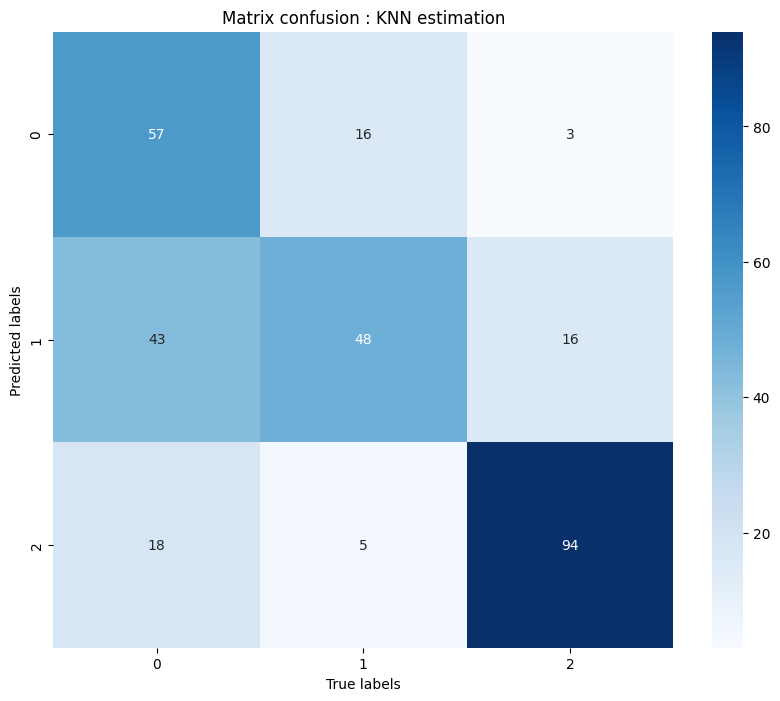

In [14]:
# Creation of the confusion matrix
y_true = dev_df['label_int']
y_pred = dev_df['label_fasttext_KNN']
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Matrix confusion : KNN estimation')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [15]:
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred,average='macro')

print("Recall :", recall)
print("Precision :", precision)
print("F1-score :", f1)

Recall : 0.6673389780866416
Precision : 0.6701871428167722
F1-score : 0.6501582385939177


# Neural network model

With the idea to increase the performance of our model, based on description, we also try a neural network, instead of KNN

## Cross validation , hyperparameter tuning


The 5 fold cross validation is run for our neural network model in order to determine the proper number of epochs for the neural network.

In [16]:
# Build early stop and reduce lr conditions
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Prepare the cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
epochs_per_fold = []

# Loop over the folds
for train_index, val_index in kfold.split(train_vectors,train_labels):

    # Get the data from the fold
    X_train_fold, X_val_fold = train_vectors[train_index], train_vectors[val_index]
    y_train_fold, y_val_fold = np.array(train_labels)[train_index], np.array(train_labels)[val_index]

    # Create the two models : one that output the labels, and another that output the logits
    model_classification = models.Sequential()
    model_logits = models.Sequential()

    # Build the model architecture
    input_layer = layers.Input(shape=(301,), name='input_layer')
    model_classification.add(input_layer)
    model_logits.add(input_layer)

    for units in [1024, 1024, 512, 512, 256, 256, 128, 128, 64, 64, 32, 32]:

        dense_layer = layers.Dense(units, activation='relu')
        relu_layer = LeakyReLU(alpha=0.1)
        batch_norm_layer = layers.BatchNormalization()
        dropout_layer = layers.Dropout(0.3 if units > 128 else 0.2)

        model_classification.add(dense_layer)
        model_classification.add(relu_layer)
        model_classification.add(batch_norm_layer)
        model_classification.add(dropout_layer)

    # add the final layer, only to the classification model
    logits_layer = layers.Dense(3, name='logits_layer')
    model_classification.add(logits_layer)

    softmax_layer = layers.Softmax(name='softmax_layer')
    model_classification.add(softmax_layer)

    # Compilation
    model_classification.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Convert label to categorical variable
    train_labels_nn = to_categorical(train_labels, num_classes=3)
    dev_labels_nn = to_categorical(dev_labels, num_classes=3)




    history = model_classification.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=200,
        batch_size=64,
        callbacks=[early_stop, reduce_lr]
    )

    epochs_per_fold.append(len(history.history['loss']))


print(f"Average number of epochs per fold is : {np.mean(epochs_per_fold)}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.3541 - loss: 1.5928 - val_accuracy: 0.4301 - val_loss: 1.0713 - learning_rate: 0.0010
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.3995 - loss: 1.2529 - val_accuracy: 0.4301 - val_loss: 1.0904 - learning_rate: 0.0010
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.4946 - loss: 1.0711 - val_accuracy: 0.4301 - val_loss: 1.0964 - learning_rate: 0.0010
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.5163 - loss: 1.0001 - val_accuracy: 0.5108 - val_loss: 0.9696 - learning_rate: 0.0010
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5773 - loss: 0.9081 - val_accuracy: 0.6019 - val_loss: 0.8374 - learning_rate: 0.0010
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.5891 - loss: 0.8703 - val_accuracy: 0.6331 - val_loss: 0.7721 - learning_rate: 0.0010
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.6132 - loss: 0.835

### Retraining on the  entire training set

Now, knowing the number of epochs we are retraining the model on the whole training set

In [19]:
# Build the two models
model_classification = models.Sequential()
model_logits = models.Sequential()

# Input
input_layer = layers.Input(shape=(301,), name='input_layer')
model_classification.add(input_layer)
model_logits.add(input_layer)

# Loop over blocs
for units in [1024, 1024, 512, 512, 256, 256, 128, 128, 64, 64, 32, 32]:

    # design the layers
    dense_layer = layers.Dense(units, activation='relu')
    relu_layer = LeakyReLU(alpha=0.1)
    batch_norm_layer = layers.BatchNormalization()
    dropout_layer = layers.Dropout(0.3 if units > 128 else 0.2)

    # add layers to classification model
    model_classification.add(dense_layer)
    model_classification.add(relu_layer)
    model_classification.add(batch_norm_layer)
    model_classification.add(dropout_layer)

    # add layers to logit models
    model_logits.add(dense_layer)
    model_logits.add(relu_layer)
    model_logits.add(batch_norm_layer)
    model_logits.add(dropout_layer)

# Add final layers
logits_layer = layers.Dense(3, name='logits_layer')
model_classification.add(logits_layer)
model_logits.add(logits_layer)

softmax_layer = layers.Softmax(name='softmax_layer')
model_classification.add(softmax_layer)

# Compile
model_classification.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Convert label to categorical variable
train_labels_nn = to_categorical(train_labels, num_classes=3)
dev_labels_nn = to_categorical(dev_labels, num_classes=3)


history = model_classification.fit(
    train_vectors, train_labels_nn,
    epochs=math.floor(np.mean(epochs_per_fold))-1,
    batch_size=64,
)

# Prediction
logits_dev = model_logits.predict(dev_vectors)
logits_train = model_logits.predict(train_vectors)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/27
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.3654 - loss: 1.4248
Epoch 2/27
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.4508 - loss: 1.1164
Epoch 3/27
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.5436 - loss: 0.9621
Epoch 4/27
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.5791 - loss: 0.9005
Epoch 5/27
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5946 - loss: 0.8525
Epoch 6/27
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.6347 - loss: 0.8032
Epoch 7/27
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6532 - loss: 0.7738
Epoch 8/27
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.6437 - loss: 0.7674
Epoch 9/27
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6871 - loss: 0.7121
Epoch 10/27
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.6890 - loss: 0.6904
Epoch 11/27
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.6961 - loss: 0.6887
Epoch 12/27
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accur

### Evaluation
Evaluation on the train and dev set now

In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Prepare the data for the evaluation
y_dev_pred = model_classification.predict(dev_vectors)
y_train_pred = model_classification.predict(train_vectors)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_dev_pred_classes = np.argmax(y_dev_pred, axis=1)
y_dev_true_classes = np.argmax(dev_labels_nn, axis=1)
y_train_true_classes = np.argmax(train_labels_nn, axis=1)

# Accuracy
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes)
dev_accuracy = accuracy_score(y_dev_true_classes, y_dev_pred_classes)
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train_true_classes, y_train_pred_classes, average='weighted')
dev_precision, dev_recall, dev_f1, _ = precision_recall_fscore_support(y_dev_true_classes, y_dev_pred_classes, average='weighted')

# Print
print(f"Train accuracy : {train_accuracy * 100:.2f}%")
print(f"Train precision: {train_precision * 100:.2f}%")
print(f"Train recall   : {train_recall * 100:.2f}%")
print(f"Train F1-score : {train_f1 * 100:.2f}%")
print(f"Dev accuracy   : {dev_accuracy * 100:.2f}%")
print(f"Dev precision  : {dev_precision * 100:.2f}%")
print(f"Dev recall     : {dev_recall * 100:.2f}%")
print(f"Dev F1-score   : {dev_f1 * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Train accuracy : 90.74%
Train precision: 90.86%
Train recall   : 90.74%
Train F1-score : 90.78%
Dev accuracy   : 68.67%
Dev precision  : 70.23%
Dev recall     : 68.67%
Dev F1-score   : 69.13%


# NN exportation


In [21]:
from huggingface_hub import login, create_repo, upload_folder
import os
import tensorflow as tf
from huggingface_hub import hf_hub_download

login(token="")

repo_name = "MNLP-HW1"
repo_id = f"tgarnier067/{repo_name}"
create_repo(repo_id, exist_ok=True, private=False)
model_folder = "models"
os.makedirs(model_folder, exist_ok=True)
models = {
    "model_logits_description": model_logits
}

# Save the models in separate files
for model_name, model in models.items():
    model_file_path = os.path.join(model_folder, f"{model_name}.keras")
    model.save(model_file_path)

# Add a default README
readme_content = """# MNLP HW1 Models
This repository contains multiple models trained for different tasks. Each model is saved as a separate `.keras` file.
"""

# Create a README.md file in the model folder
with open(os.path.join(model_folder, "README.md"), "w") as f:
    f.write(readme_content)

# Upload all models to the Hugging Face repo
upload_folder(
    repo_id=repo_id,
    folder_path=model_folder,
    path_in_repo=""
)

print(f"All models have been successfully uploaded to Hugging Face in the repo {repo_id}!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9561: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


model_logits_description.keras:   0%|          | 0.00/9.86M [00:00<?, ?B/s]

All models have been successfully uploaded to Hugging Face in the repo tgarnier067/MNLP-HW1!
